**1. Data Preprocessing & Cleaning**

In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.0 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import string
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def text_cleaning_pipeline(text, rule="lemmatize"):
    """
    Cleans text data using several preprocessing steps.

    Args:
        text (str): Raw input text.
        rule (str): 'lemmatize' or 'stem'.

    Returns:
        str: Cleaned and processed text.
    """

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization or stemming
    if rule == "lemmatize":
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    elif rule == "stem":
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        raise ValueError("Invalid rule. Choose between 'lemmatize' or 'stem'.")

    return " ".join(tokens)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/AI/trum_tweet_sentiment_analysis.csv')

In [ ]:
data.columns

Index(['text', 'Sentiment'], dtype='object')

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

data['cleaned_text'] = data['text'].progress_apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))


  0%|          | 0/1850123 [00:00<?, ?it/s]

**2. Tokenization & Padding**

In [ ]:
data.rename(columns={'Sentiment': 'sentiment'}, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['sentiment_encoded'],
    test_size=0.2,
    random_state=42
)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
import numpy as np

seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))  # e.g., 95% of sequences are this long or shorter


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


**3. Model Building**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

vocab_size = 10000  # same as tokenizer
embedding_dim = 128


In [ ]:
#  RNN Model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**4. Training & Evaluation**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [ ]:
# Train RNN
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 169s 4ms/step - accuracy: 0.9105 - loss: 0.2231 - val_accuracy: 0.9524 - val_loss: 0.1355
Epoch 2/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 198s 4ms/step - accuracy: 0.9574 - loss: 0.1224 - val_accuracy: 0.9553 - val_loss: 0.1282
Epoch 3/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 183s 4ms/step - accuracy: 0.9614 - loss: 0.1128 - val_accuracy: 0.9525 - val_loss: 0.1361
Epoch 4/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 146s 4ms/step - accuracy: 0.9619 - loss: 0.1118 - val_accuracy: 0.9521 - val_loss: 0.1398


In [ ]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,877,253 (14.79 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,584,836 (9.86 MB)

In [ ]:
# Train LSTM
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 251s 7ms/step - accuracy: 0.9203 - loss: 0.1977 - val_accuracy: 0.9619 - val_loss: 0.1074
Epoch 2/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 263s 7ms/step - accuracy: 0.9672 - loss: 0.0927 - val_accuracy: 0.9669 - val_loss: 0.0947
Epoch 3/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 247s 7ms/step - accuracy: 0.9747 - loss: 0.0720 - val_accuracy: 0.9684 - val_loss: 0.0897
Epoch 4/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 251s 6ms/step - accuracy: 0.9794 - loss: 0.0590 - val_accuracy: 0.9696 - val_loss: 0.0907
Epoch 5/5
37003/37003 ━━━━━━━━━━━━━━━━━━━━ 249s 7ms/step - accuracy: 0.9826 - loss: 0.0495 - val_accuracy: 0.9703 - val_loss: 0.0904


In [ ]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 17, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,421 (15.21 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,658,948 (10.14 MB)

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step


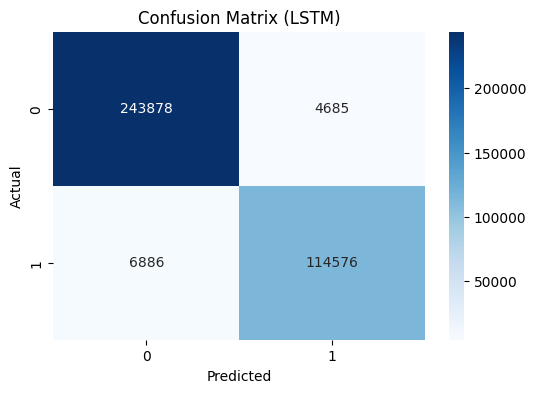

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data using LSTM model
y_pred_probs = lstm_model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LSTM)')
plt.show()



In [ ]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     0.9725    0.9812    0.9768    248563
           1     0.9607    0.9433    0.9519    121462

    accuracy                         0.9687    370025
   macro avg     0.9666    0.9622    0.9644    370025
weighted avg     0.9687    0.9687    0.9687    370025



**5. Visualization**

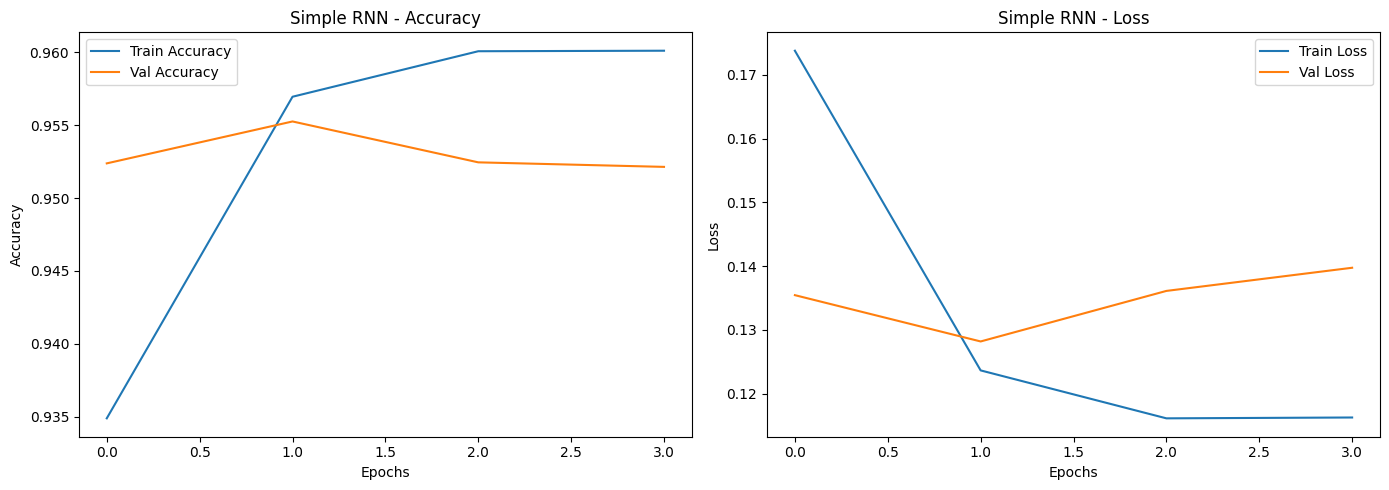

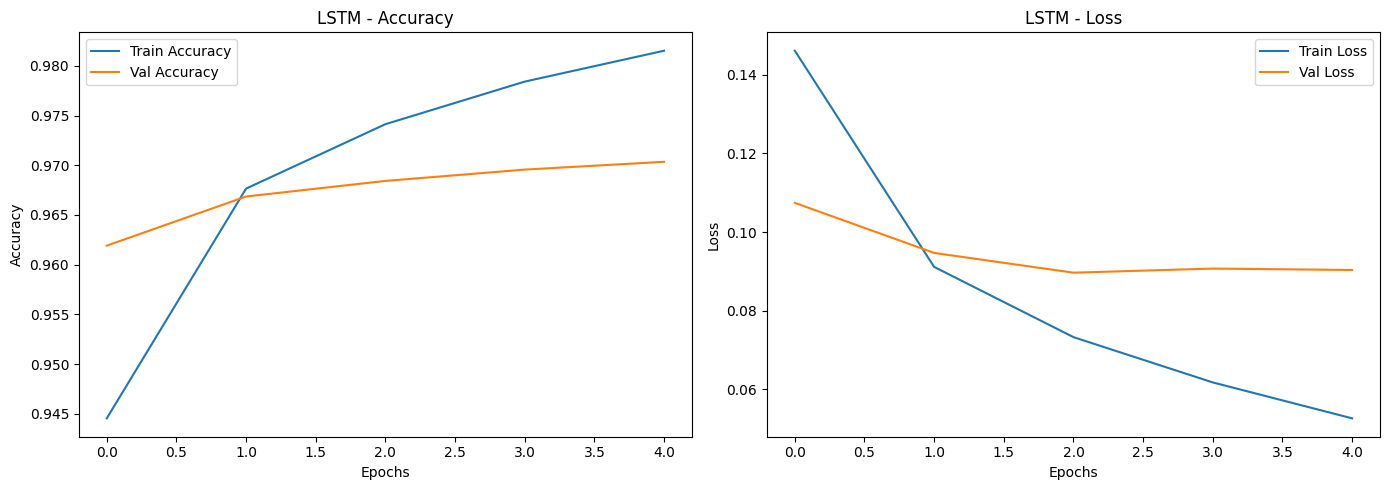

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for RNN
plot_history(history_rnn, "Simple RNN")

# Plot for LSTM
plot_history(history_lstm, "LSTM")


**6. (Optional) GUI for Real-Time Prediction**

In [3]:
import ipywidgets as widgets
import re
from keras.preprocessing.sequence import pad_sequences


def predict_sentiment(tweet):
    cleaned = text_cleaning_pipeline(tweet)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = lstm_model.predict(pad)
    label = int(pred[0][0] > 0.5)
    sentiment = label_encoder.inverse_transform([label])[0]
    return sentiment

input_box = widgets.Text(
    value='',
    placeholder='Type a tweet here...',
    description='Tweet:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)
output_box = widgets.Output()

def on_button_clicked(b):
    with output_box:
        clear_output()
        tweet = input_box.value
        if tweet.strip() == "":
            print("Please enter a tweet.")
            return
        sentiment = predict_sentiment(tweet)
        print(f"Sentiment: {sentiment}")

button = widgets.Button(description="Predict Sentiment", button_style='primary')
button.on_click(on_button_clicked)

